In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("ETEtotal_merged_reviewsfinal.csv")
df.head()

,Rating,Review,Name
0,5.0,I visited Kebabs & Curries with a non-vegetari...,NaN
1,5.0,"In a city dominated by vegetarian food, this p...",NaN
2,1.0,Im Athrv Joshi living in jaipur rajasthan 3020...,NaN
3,5.0,The place is good to go all the time for a qui...,NaN
4,5.0,Kebabs and curry serves the most authentic non...,NaN


In [3]:
df = df.drop("Name",axis=1)
df.head()

,Rating,Review
0,5.0,I visited Kebabs & Curries with a non-vegetari...
1,5.0,"In a city dominated by vegetarian food, this p..."
2,1.0,Im Athrv Joshi living in jaipur rajasthan 3020...
3,5.0,The place is good to go all the time for a qui...
4,5.0,Kebabs and curry serves the most authentic non...


In [4]:
df['Review'] = df['Review'].str.lower()
df.head()

,Rating,Review
0,5.0,i visited kebabs & curries with a non-vegetari...
1,5.0,"in a city dominated by vegetarian food, this p..."
2,1.0,im athrv joshi living in jaipur rajasthan 3020...
3,5.0,the place is good to go all the time for a qui...
4,5.0,kebabs and curry serves the most authentic non...


In [5]:
import re
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [6]:
import spacy
nlp = spacy.load("en_core_web_sm")

df['Review'] = df['Review'].apply(lambda x: [token.text for token in nlp(x)])

In [7]:
print(df['Review'].head())

0    [i, visited, kebabs,  , curries, with, a, nonv...
1    [in, a, city, dominated, by, vegetarian, food,...
2    [i, m, athrv, joshi, living, in, jaipur, rajas...
3    [the, place, is, good, to, go, all, the, time,...
4    [kebabs, and, curry, serves, the, most, authen...
Name: Review, dtype: object


In [8]:
df['Processed_Review'] = df['Review'].apply(lambda x: [
    token.lemma_ for token in nlp(" ".join(x)) if not token.is_stop
])

In [9]:
print(df['Processed_Review'].head())

0    [visit, kebab,   , curry, nonvegetarian, frien...
1    [city, dominate, vegetarian, food, place, boon...
2    [m, athrv, joshi, live, jaipur, rajasthan,   ,...
3    [place, good, time, quick, bite, belly, feast,...
4    [kebab, curry, serve, authentic, non, veg, cit...
Name: Processed_Review, dtype: object


In [10]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert ratings (1-5) to categorical format
y = to_categorical(df['Rating'] - 1, num_classes=5)  # Subtract 1 to make labels 0-based

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Processed_Review'])  # Train tokenizer on tokenized data

# Convert tokens to sequences
X = tokenizer.texts_to_sequences(df['Processed_Review'])

# Padding sequences
X = pad_sequences(X, padding='post')

# Define vocab_size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token

In [12]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (1012, 237) (1012, 5)
Testing data shape: (254, 237) (254, 5)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential([
    Input(shape=(X.shape[1],)),
    Embedding(input_dim=vocab_size, output_dim=128),  # Define input shape
    LSTM(64,return_sequences = True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes for star ratings
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 237, 128)       │       366,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 237, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 237, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,837 (1.64 MB)

 Trainable params: 428,837 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size = 4)

val_loss, val_acc = model.evaluate(X_train,y_train)
print(f"Validation accuracy:{val_acc:.4f} loss:{val_loss:.4f}")

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4618 - loss: 1.4040 - val_accuracy: 0.4646 - val_loss: 1.3730
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4472 - loss: 1.4329 - val_accuracy: 0.4646 - val_loss: 1.3765
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4799 - loss: 1.3662 - val_accuracy: 0.4646 - val_loss: 1.3722
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.4614 - loss: 1.3736 - val_accuracy: 0.4646 - val_loss: 1.3743
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4418 - loss: 1.3922 - val_accuracy: 0.4646 - val_loss: 1.3714
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4846 - loss: 1.3543 - val_accuracy: 0.4646 - val_loss: 1.3717
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4599 - loss: 1.3790 - val_accuracy: 0.4646 - val_loss: 1.3718
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.4663 - loss: 1.3694 - 

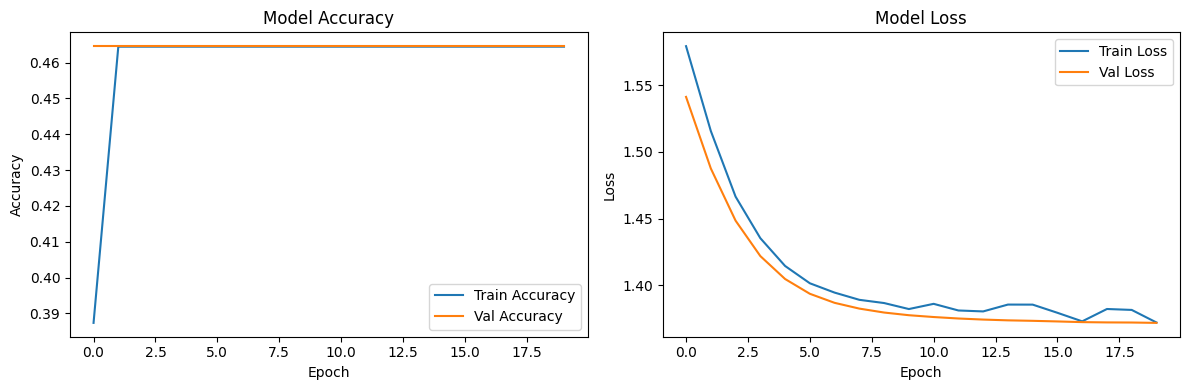

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()